In [39]:
from PIL import Image
import numpy as np
import os

def load_data(*path: str, labels: list, skip: bool = True) -> np.ndarray:
    """
    Loads data from a given path and returns a numpy array with the image and label of each file.

    Parameters:
    -----------
    path: str -> Path to the data folder. (can be multiple paths)
    labels: list -> List of labels for each path.
    skip: bool -> Skip files that are not images or cannot be read. (default: True)

    Returns:
    --------
    data_array: np.ndarray -> Numpy array with the image and label of each file.
    """

    # list to store the data. 
    data_array = []
    skipped_files = 0 # Number of skipped files.

    # ---------------------------------------------------
    # Check if the number of paths and labels are equal.
    # If not equal raise an error.
    # ---------------------------------------------------
    if len(path) == len(labels):

        # Loop through the paths and labels.
        for p, l in zip(path, labels):

            # --------------------------
            # Check if the path exists.
            # If not raise an error.
            # --------------------------    
            if os.path.exists(p):
                
                # ----------------------------------------------
                # Loop through the files in the path.
                # Append the image and label to the list.
                # ----------------------------------------------
                for file in os.listdir(p):
                    # Try to catch errors when reading the image.
                    try:
                        # Append the image and label to the list.
                        data_array.append([Image.open(os.path.join(p, file)), l])

                    except Image.UnidentifiedImageError as e:
                        # If skip is True, skip the file.
                        if skip:
                            skipped_files += 1 
                        else:
                            raise e
            else:
                raise FileNotFoundError("Path does not exist")
    else:
        raise ValueError("Number of paths and labels must be equal")
    
    if skipped_files > 0:
        print(f"Skipped {skipped_files} files")

    # Return the numpy array.
    return np.array(data_array, dtype=object)


def resize_images(images: np.array, size: tuple) -> np.array:
    """
    Resizes images in a numpy array.

    Parameters:
    -----------
    images: np.array -> Numpy array with images.
    size: tuple -> Size to resize the images. (width, height)

    Returns:
    --------
    images: np.array -> Numpy array with the resized images.
    """
    
    # Loop through the images and resize them.
    for index, image in enumerate(images):
        images[index][0] = image[0].resize(size)

    # Retruns the numpy array.
    return images


def convert_to_array(dataset: np.array) -> np.array:
    """
    Converts images in a numpy array to numpy arrays.

    Parameters:
    -----------
    dataset: np.array -> Numpy array with images.

    Returns:
    --------
    dataset: np.array -> Numpy array with the images converted to numpy arrays.
    """

    # Loop through the images and convert them to numpy arrays. 
    for index, image in enumerate(dataset):
        dataset[index][0] = np.array(image[0])

    # Return the numpy array.
    return dataset

Skipped 389 files


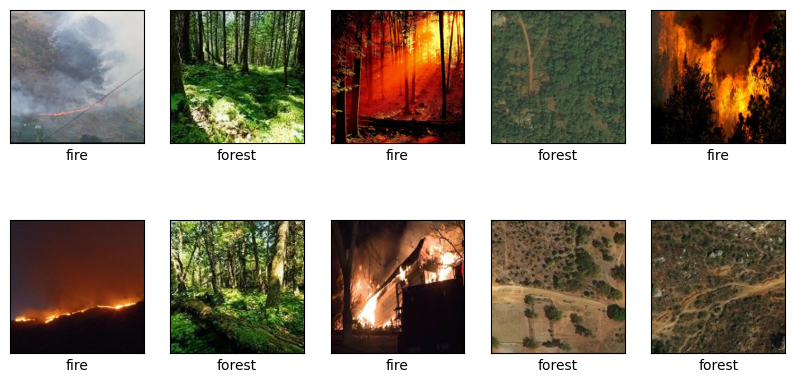

dataset len: 4773
dataset shape: (4773, 2)
dataset fire images: 2111
dataset forest images: 2662


In [40]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

path_fire = './Data/fire/fire/fire-images/'
path_forest = './Data/fire/fire/forest-images/'

# ------------------------------
# Load the data.
# Resize the images to 256x256.
# ------------------------------
dataset = load_data(path_fire, path_forest, labels=['fire', 'forest'])
dataset = resize_images(dataset, (256, 256))

# Shuffle the dataset.
np.random.shuffle(dataset)

# Sample 10 images from the dataset.
plt.figure(figsize=(10, 5))
for index, image in enumerate(dataset[:10]):
    plt.subplot(2, 5, index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[0], cmap=plt.cm.binary)
    plt.xlabel(image[1])
plt.show()

# ------------------------
# Print the dataset info.
# ------------------------ 
print(f"dataset len: {len(dataset)}")
print(f"dataset shape: {dataset.shape}")
print(f"dataset fire images: {len([index for index in dataset if index[1] == 'fire'])}")
print(f"dataset forest images: {len([index for index in dataset if index[1] == 'forest'])}")

# --------------------------------------------
# Convert the images to numpy arrays.
# Split the dataset into train and test sets.
# --------------------------------------------
dataset = convert_to_array(dataset)
X_train, X_test, y_train, y_test = train_test_split(dataset[:, 0], dataset[:, 1], test_size=0.2, random_state=42)

In [41]:
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# --------------------------------------------------------------
# The model structure: 
# 3 Conv2D layers, with 16, 32 and 64 filters and a kernal 3x3.
# 3 Maxpooling2D layers, with size 2x2.
# 1 Flatten layer.
# 2 Dense layers with units 1024 and 5. 
# --------------------------------------------------------------  
model = Sequential([
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(units=1024, activation='relu'),
    layers.Dense(units=5, activation='softmax')
])

# Building and training the model. 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, validation_split=0.2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).